### Suriya Kasiyalan Siva
#### HW 3
#### Part 2 and Part 3

In [25]:
%matplotlib inline
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import itertools
# initializing gtsam
!pip install gtsam
import gtsam
import gtsam.utils.plot as gtsam_plot
import math

In [26]:
#loading images from the folder
def load_images_from_folder(folder_path):
    images = []
    filenames = sorted(os.listdir(folder_path)) 
    for filename in filenames:
        file_path = os.path.join(folder_path, filename)
        image = cv2.imread(file_path)
        if image is not None:
            images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    return images

# Applying Clahe
def apply_clahe(image):
    """Apply CLAHE to the input image and return the enhanced image."""
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8, 8))
    clahe_image = clahe.apply(gray_image)
    enhanced_image = cv2.merge([clahe_image, clahe_image, clahe_image])
    return enhanced_image

def detect_and_compute_sift(image):
    sift = cv2.SIFT_create(nfeatures=7000,
            nOctaveLayers=12,
            contrastThreshold=0.025,
            sigma=1.5)
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors



def find_matches(source_keypoints, src_descriptors, target_keypoints, dst_descriptors):
    # Create a BFMatcher object with L2 norm
    bf = cv2.BFMatcher(cv2.NORM_L2)

    # Find matches using k-nearest neighbors (k=2)
    matches = bf.knnMatch(src_descriptors, dst_descriptors, k=2)
    cross_matches = bf.match(dst_descriptors, src_descriptors) 
    cross_match_dict = {cross_match.trainIdx: cross_match.queryIdx for cross_match in cross_matches}
    
    good_matches = []
    src_points = []
    dst_points = []

    # Ratio test to filter good matches
    for match_1, match_2 in matches:
        # Check for cross-match consistency and apply ratio test
        if (match_1.queryIdx in cross_match_dict and
            cross_match_dict[match_1.queryIdx] == match_1.trainIdx and
            match_1.distance < 0.75 * match_2.distance):

            good_matches.append(match_1)
            # Correctly access the pt attribute of KeyPoint
            src_points.append(source_keypoints[match_1.queryIdx].pt) 
            dst_points.append(target_keypoints[match_1.trainIdx].pt)  

    src_pts = np.float32(src_points).reshape(-1, 2)
    dst_pts = np.float32(dst_points).reshape(-1, 2)
    return good_matches, src_pts, dst_pts

# Function to calculate the affine matrix using cv2.estimateAffinePartial2D
def calculate_affinematrix(src_pts, dst_pts, good_matches):
    if len(good_matches) < 10:
        return None, None

    # Estimate affine partial 2D transformation (2x3 affine matrix)
    affine_matrix, inliers = cv2.estimateAffinePartial2D(dst_pts, src_pts, method=cv2.RANSAC)

    if affine_matrix is None:
        return None, None
    scale_factor = math.sqrt(affine_matrix[0, 0]**2 + affine_matrix[0, 1]**2)
    affine_matrix[:2, :2] *= scale_factor
    # Calculate diagonal noise  inspired from the referance code give by professor 
    diagonal_noise = 1000 * len(inliers) ** -2 * np.array([1, 1, np.deg2rad(1)])
    gtsam_noise_model = gtsam.noiseModel.Diagonal.Sigmas(diagonal_noise)

    return affine_matrix, gtsam_noise_model


# Function to convert affine matrix to GTSAM Pose2 object
def convert_to_gtsam_pose(affine_matrix):
    translation_x = affine_matrix[0, -1]
    translation_y = affine_matrix[1, -1]
    theta = np.arctan2(affine_matrix[1, 0], affine_matrix[0, 0])
    return gtsam.Pose2(translation_x, translation_y, theta)

# Function to initialize GTSAM with the poses based on consecutive matches
def initialize_gtsam(images, initial_poses):
    cumulative_affine_matrix = np.eye(3)  
    initial_poses.insert(0, gtsam.Pose2())

    for source_index in range(len(images) - 1):
        target_index = source_index + 1

        # Apply CLAHE to images before SIFT detection
        source_image = apply_clahe(images[source_index])
        target_image = apply_clahe(images[target_index])

        source_keypoints, source_descriptors= detect_and_compute_sift(source_image)
        target_keypoints, target_descriptors= detect_and_compute_sift(target_image)

        good_matches, src_pts, dst_pts = find_matches(source_keypoints, source_descriptors, target_keypoints, target_descriptors)
        affine_matrix, gtsam_noise = calculate_affinematrix(src_pts, dst_pts, good_matches)

        if affine_matrix is None:
            continue

        affine_homogeneous = np.eye(3)
        affine_homogeneous[:2, :] = affine_matrix
        # Multiply with the cumulative affine matrix
        cumulative_affine_matrix = affine_homogeneous @ cumulative_affine_matrix

        initial_poses.insert(target_index, convert_to_gtsam_pose(cumulative_affine_matrix))

    return cumulative_affine_matrix, initial_poses



# Function to build GTSAM graph
def build_gtsam_graph(folder: str, use_sift: bool = True):
    images = load_images_from_folder(folder)

    prior_noise_model = gtsam.noiseModel.Diagonal.Sigmas(np.array([10, 10, np.deg2rad(10)]))
    initial_poses = gtsam.Values()

    graph = gtsam.NonlinearFactorGraph()
    image_height, image_width = images[0].shape[:2]

    graph.add(gtsam.PriorFactorPose2(0, gtsam.Pose2(image_width / 2, image_height / 2, 0), prior_noise_model))

    total_affine_matrix = np.eye(3)

    cumulative_affine_matrix, initial_poses = initialize_gtsam(images, initial_poses)

    for source_index, target_index in itertools.combinations(range(len(images)), 2):
        if source_index + 1 == target_index:
            source_image = apply_clahe(images[source_index])
            target_image = apply_clahe(images[target_index])

            source_keypoints, source_descriptors = detect_and_compute_sift(source_image)
            target_keypoints, target_descriptors = detect_and_compute_sift(target_image)

            good_matches, src_pts, dst_pts = find_matches(source_keypoints, source_descriptors, target_keypoints, target_descriptors)
            affine_matrix, gtsam_noise = calculate_affinematrix(src_pts, dst_pts, good_matches)

            if affine_matrix is None:
                continue

            affine_homogeneous = np.eye(3)
            affine_homogeneous[:2, :] = affine_matrix
            total_affine_matrix = affine_homogeneous @ total_affine_matrix
            graph.add(gtsam.BetweenFactorPose2(source_index, target_index,
                                               convert_to_gtsam_pose(affine_homogeneous), gtsam_noise))
            print(f"Between factor added between {source_index} and {target_index} is stored successfully")

        elif cv2.norm(initial_poses.atPose2(source_index).translation() - initial_poses.atPose2(target_index).translation()) < image_width * 0.8:
            source_image = apply_clahe(images[source_index])
            target_image = apply_clahe(images[target_index])

            source_keypoints, source_descriptors = detect_and_compute_sift(source_image)
            target_keypoints, target_descriptors = detect_and_compute_sift(target_image)

            good_matches, src_pts, dst_pts = find_matches(source_keypoints, source_descriptors, target_keypoints, target_descriptors)
            affine_matrix, gtsam_noise = calculate_affinematrix(src_pts, dst_pts, good_matches)

            if affine_matrix is None:
                continue

            affine_homogeneous = np.eye(3)
            affine_homogeneous[:2, :] = affine_matrix
            total_affine_matrix = affine_homogeneous @ total_affine_matrix
            graph.add(gtsam.BetweenFactorPose2(source_index, target_index,
                                               convert_to_gtsam_pose(affine_homogeneous), gtsam_noise))
            print(f"Between factor added between {source_index} and {target_index} is stored successfully")

    return graph, initial_poses, images



# Function to plot the poses
def plot_poses(values, graph, marginals):
    plt.figure()

    # Plot all the poses
    for vertex_index in range(values.size()):
        pose = values.atPose2(vertex_index)
        gtsam.utils.plot.plot_pose2(0, pose, 0.5, marginals.marginalCovariance(vertex_index))
        plt.text(pose.x(), pose.y(), str(vertex_index), fontsize=8)
    # Plot all the edges between poses
    for edge_index in range(graph.size()):
        factor = graph.at(edge_index)
        if isinstance(factor, gtsam.BetweenFactorPose2):  
            key1, key2 = factor.keys()

            start_pose = values.atPose2(key1)
            end_pose = values.atPose2(key2)

            # Plot a line between the poses
            plt.plot([start_pose.x(), end_pose.x()],
                     [start_pose.y(), end_pose.y()],
                     color='blue')

    plt.title('Poses and Between Factors')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.axis('equal')
    plt.grid(True)
    plt.show()

# Function to optimize the GTSAM graph
def optimize_graph(graph, initial_poses):
    params = gtsam.LevenbergMarquardtParams()
    optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_poses, params)
    optimized_poses = optimizer.optimize()
    return optimized_poses

Stitching images

In [27]:
def create_panorama(images, graph, initial, blend=False, scale=1):
    poses = gtsam.utilities.allPose2s(initial)
    panorama_parts = []

    # Calculate affine matrices from poses and populate panorama parts
    for index in range(len(images)):
        pose = poses.atPose2(index)
        affine_matrix = pose.matrix()
        panorama_parts.append({"img": images[index], "affine": affine_matrix})

    # Find canvas dimensions
    img_points = []
    for part in panorama_parts:
        h = part["affine"]
        img_points.extend([
            h.dot(np.array([0, 0, 1]).T)[:-1],                     
            h.dot(np.array([images[0].shape[1] - 1, 0, 1]).T)[:-1], 
            h.dot(np.array([images[0].shape[1] - 1, images[0].shape[0] - 1, 1]).T)[:-1], 
            h.dot(np.array([0, images[0].shape[0] - 1, 1]).T)[:-1] 
        ])
    img_points = np.array(img_points)
    min_corner = np.floor(np.amin(img_points, axis=0)).astype(np.int32)
    max_corner = np.ceil(np.amax(img_points, axis=0)).astype(np.int32)
    canvas_size = (max_corner - min_corner + 1).astype(np.int32)

    # Adjust the affine matrices
    transH = np.eye(3)
    transH[0, 2] = -min_corner[0]
    transH[1, 2] = -min_corner[1]
    for part in panorama_parts:
        part["affine"] = np.matmul(transH, part["affine"])

    # Warp images and stitch together
    final_image = np.zeros((canvas_size[1], canvas_size[0], 3), np.uint8)
    for part in panorama_parts:
        img = part["img"]
        h_matrix = part["affine"]
        warped_img = cv2.warpPerspective(img, h_matrix, (canvas_size[0], canvas_size[1]))

        # Blending option
        if blend:
            final_image = np.where(warped_img != 0, warped_img, final_image)
        else:
            final_image = cv2.add(final_image, warped_img)

    # Scale the final image
    if scale != 1:
        final_image = cv2.resize(final_image, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)

    return final_image

In [28]:
folder_path_1 = r'/content/drive/MyDrive/AFR/HW3/Images_6'
folder_path_2 = r'/content/drive/MyDrive/AFR/HW3/29images/full'
folder_path_3 = r'/content/drive/MyDrive/AFR/HW3/tape018'

# 6 images

Loading 6 images...
Do images exist in the folder: True
Between factor added between 0 and 1 is stored successfully
Between factor added between 0 and 2 is stored successfully
Between factor added between 0 and 5 is stored successfully
Between factor added between 1 and 2 is stored successfully
Between factor added between 1 and 3 is stored successfully
Between factor added between 1 and 4 is stored successfully
Between factor added between 1 and 5 is stored successfully
Between factor added between 2 and 3 is stored successfully
Between factor added between 2 and 4 is stored successfully
Between factor added between 2 and 5 is stored successfully
Between factor added between 3 and 4 is stored successfully
Between factor added between 3 and 5 is stored successfully
Between factor added between 4 and 5 is stored successfully


<Figure size 640x480 with 0 Axes>

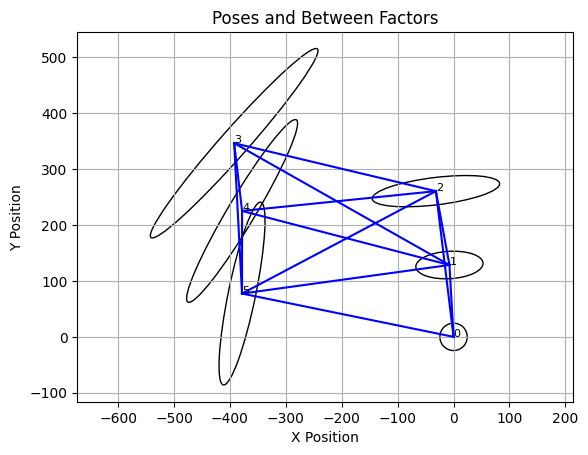

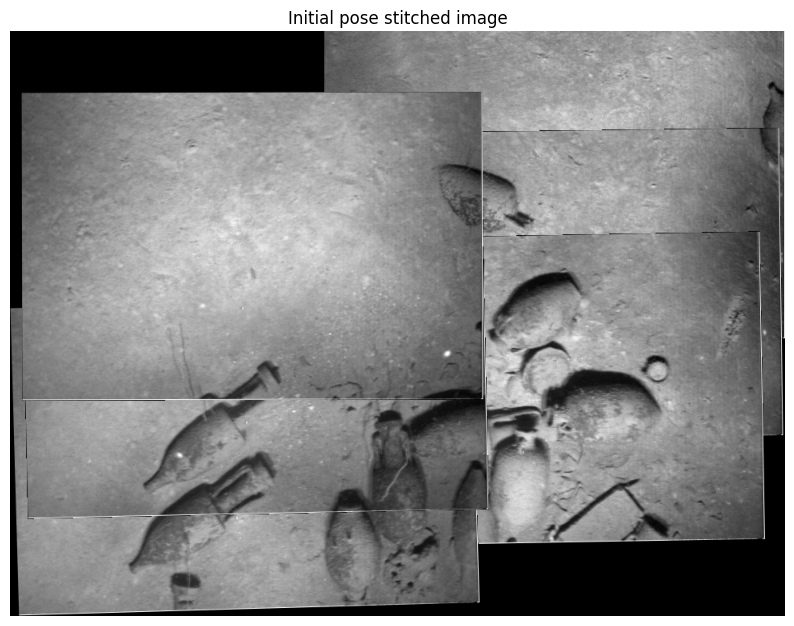

<Figure size 640x480 with 0 Axes>

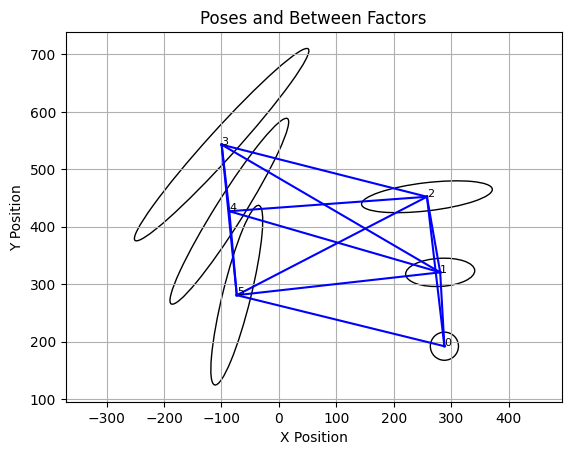

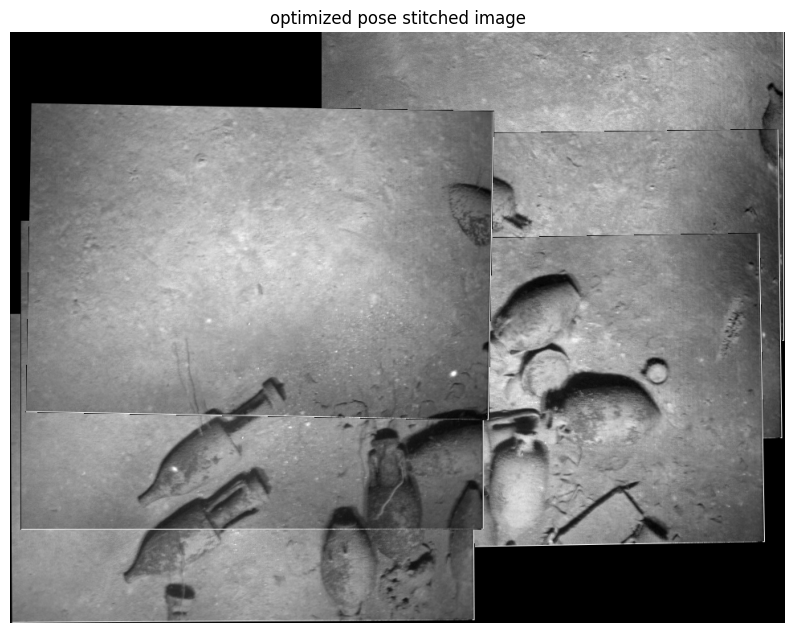

In [29]:
# Condition to choose the folder path
folder_choice = 1  

if folder_choice == 1:
    folder_path = folder_path_1
    print("Loading 6 images...")
elif folder_choice == 2:
    folder_path = folder_path_2
    print("Loading 29 images...")
elif folder_choice == 3:
    folder_path = folder_path_3
    print("Loading tape images...")
else:
    raise ValueError("Invalid folder choice. Please choose 1, 2, or 3.")

print("Do images exist in the folder:", os.path.exists(folder_path))

# initialoze the graph
graph, initial_poses, images = build_gtsam_graph(folder_path)
# Marginals for the initial graph
marginals = gtsam.Marginals(graph, initial_poses)
# Plot the initialized poses
plot_poses(initial_poses, graph, marginals)

initial_pose_stitched_image = create_panorama(images, graph, initial_poses, blend=True, scale=1)
# Display the final panorama
plt.figure(figsize=(10, 10))
plt.imshow(initial_pose_stitched_image)
plt.title('Initial pose stitched image')
plt.axis('off')
plt.show()

# Optimize the graph
optimized_poses = optimize_graph(graph, initial_poses)
# Marginals for the optimized graph
marginals = gtsam.Marginals(graph, optimized_poses)
# Plot the optimized poses
plot_poses(optimized_poses, graph, marginals)
optimized_pose_stitched_image = create_panorama(images, graph, optimized_poses, blend=True, scale=1)
# Display the final panorama
plt.figure(figsize=(10, 10))
plt.imshow(optimized_pose_stitched_image)
plt.title('optimized pose stitched image')
plt.axis('off')
plt.show()

# 29 images

Loading 29 images...
Do images exist in the folder: True
Between factor added between 0 and 1 is stored successfully
Between factor added between 0 and 2 is stored successfully
Between factor added between 0 and 11 is stored successfully
Between factor added between 0 and 12 is stored successfully
Between factor added between 1 and 2 is stored successfully
Between factor added between 1 and 3 is stored successfully
Between factor added between 1 and 11 is stored successfully
Between factor added between 1 and 12 is stored successfully
Between factor added between 2 and 3 is stored successfully
Between factor added between 2 and 4 is stored successfully
Between factor added between 2 and 5 is stored successfully
Between factor added between 2 and 7 is stored successfully
Between factor added between 2 and 8 is stored successfully
Between factor added between 2 and 9 is stored successfully
Between factor added between 2 and 10 is stored successfully
Between factor added between 2 and 11 

<Figure size 640x480 with 0 Axes>

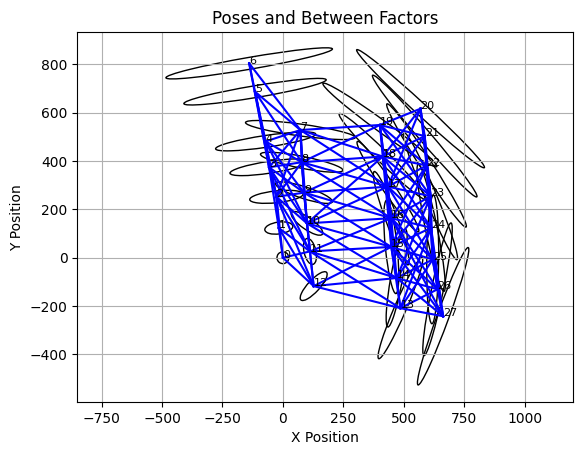

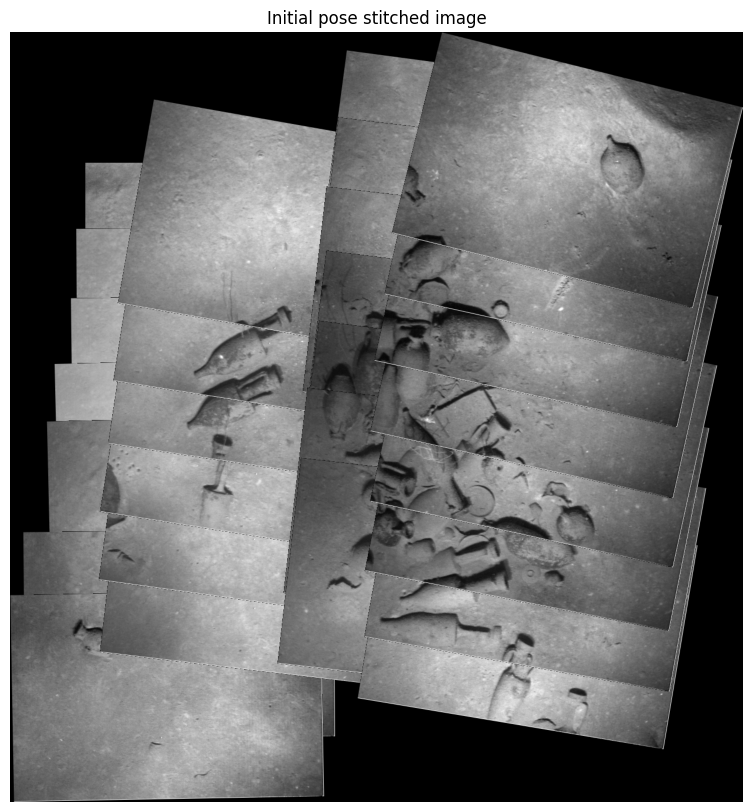

<Figure size 640x480 with 0 Axes>

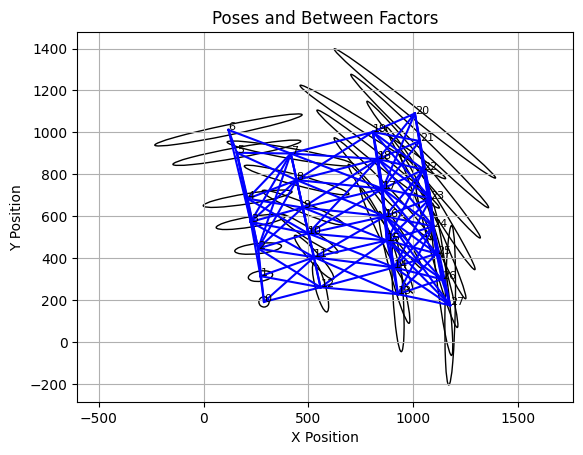

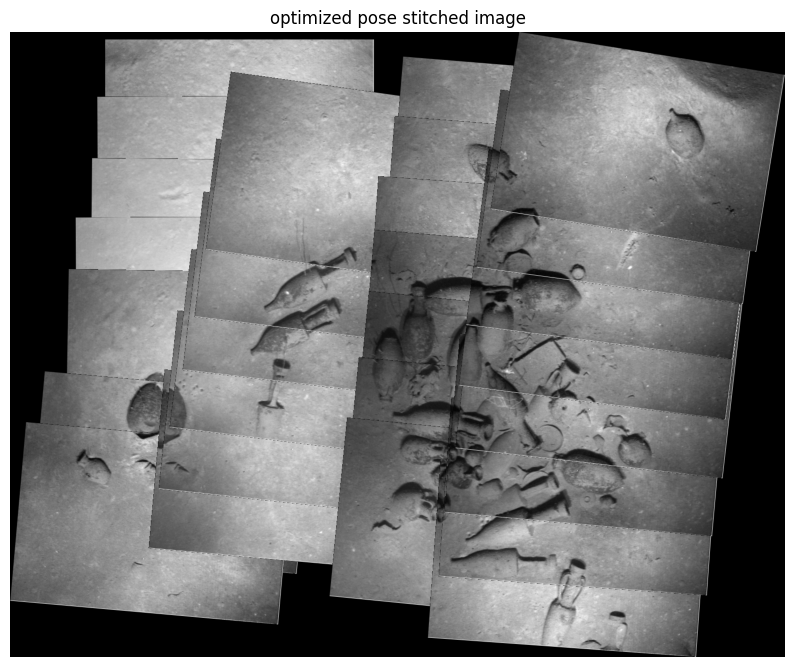

In [30]:
# Condition to choose the folder path
folder_choice = 2 

if folder_choice == 1:
    folder_path = folder_path_1
    print("Loading 6 images...")
elif folder_choice == 2:
    folder_path = folder_path_2
    print("Loading 29 images...")
elif folder_choice == 3:
    folder_path = folder_path_3
    print("Loading tape images...")
else:
    raise ValueError("Invalid folder choice. Please choose 1, 2, or 3.")

print("Do images exist in the folder:", os.path.exists(folder_path))

# initialoze the graph
graph, initial_poses, images = build_gtsam_graph(folder_path)
# Marginals for the initial graph
marginals = gtsam.Marginals(graph, initial_poses)
# Plot the initialized poses
plot_poses(initial_poses, graph, marginals)

initial_pose_stitched_image = create_panorama(images, graph, initial_poses, blend=True, scale=1)
# Display the final panorama
plt.figure(figsize=(10, 10))
plt.imshow(initial_pose_stitched_image)
plt.title('Initial pose stitched image')
plt.axis('off')
plt.show()

# Optimize the graph
optimized_poses = optimize_graph(graph, initial_poses)
# Marginals for the optimized graph
marginals = gtsam.Marginals(graph, optimized_poses)
# Plot the optimized poses
plot_poses(optimized_poses, graph, marginals)
optimized_pose_stitched_image = create_panorama(images, graph, optimized_poses, blend=True, scale=1)
# Display the final panorama
plt.figure(figsize=(10, 10))
plt.imshow(optimized_pose_stitched_image)
plt.title('optimized pose stitched image')
plt.axis('off')
plt.show()